In [1]:
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from tqdm.auto import tqdm

In [2]:
%matplotlib inline
plt.style.use('dark_background')
pio.templates.default = 'plotly_dark'

In [3]:
df = pd.read_csv(
    './test/scan.csv',
    header=None,
    names=[
    # "header",  #
    # "header.seq",  # 5
    # "header.stamp",  #
    "header.stamp.secs",  # 2829
    "header.stamp.nsecs",  #  69000000
    "header.frame_id",  # "laser_sensor_link"
    "angle_min",  # -1.57079994678
    "angle_max",  # 1.57079994678
    "angle_increment",  # 0.00436940183863
    "time_increment",  # 0.0
    "scan_time",  # 0.0
    "range_min",  # 0.10000000149
    "range_max",  # 30.0
    # float[] ranges
    *[f'R[{x:>03}]' for x in range(128)],
    'etc',
    None,
    # float[] intensities
    ],
)
df

,header.stamp.secs,header.stamp.nsecs,header.frame_id,angle_min,angle_max,angle_increment,time_increment,scan_time,range_min,range_max,...,R[120],R[121],R[122],R[123],R[124],R[125],R[126],R[127],etc,NaN
0,1770866847,793023128,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,5.898,5.896,5.889,5.884,5.873,5.873,5.867,1.956,...,NaN
1,1770866848,23144028,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,5.899,5.887,5.886,5.880,5.873,5.863,5.857,1.947,...,NaN
2,1770866848,43016481,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,5.899,5.885,5.888,5.878,5.874,5.859,5.862,1.949,...,NaN
3,1770866848,72988764,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,5.902,5.893,5.888,5.878,5.871,5.869,5.861,1.970,...,NaN
4,1770866848,93019972,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,5.898,5.898,5.886,5.885,5.880,5.868,5.860,1.961,...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,1770866851,753012950,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,1.756,1.760,1.764,1.770,1.777,1.771,1.767,1.765,...,NaN
151,1770866851,772963200,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,1.758,1.761,1.768,1.765,1.768,1.774,1.769,1.767,...,NaN
152,1770866851,802966656,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,1.761,1.756,1.768,1.761,1.764,1.780,1.775,1.761,...,NaN
153,1770866851,822968298,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,1.761,1.750,1.757,1.765,1.774,1.775,1.767,1.767,...,NaN


In [4]:
constants = {
    key: value.unique().item()
    for key, value in df.items()
    if value.nunique() == 1
}
constants

{'header.frame_id': 'laser',
 'angle_min': -2.356194496154785,
 'angle_max': 2.356194496154785,
 'angle_increment': 0.0043633230961859,
 'time_increment': 1.736111516947858e-05,
 'scan_time': 0.025000000372529,
 'range_min': 0.0199999995529651,
 'range_max': 30.0,
 'etc': '...'}

In [5]:
rs = np.array(df.filter(like='R'))
rs.shape

(155, 128)

In [6]:
@ipywidgets.interact
def _(i: ipywidgets.IntSlider(10, 0, len(rs))):
    return px.scatter(rs[i], range_y=[0, 10])

interactive(children=(IntSlider(value=10, description='i', max=155), Output()), _dom_classes=('widget-interact…

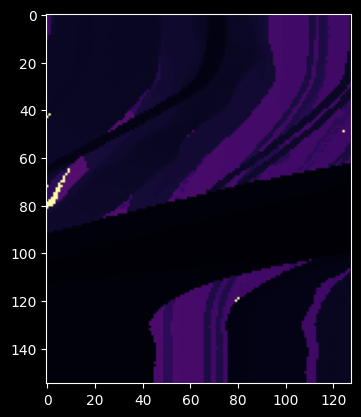

In [7]:
fig, ax  = plt.subplots()
ax.imshow(rs, cmap='inferno', vmin=0, vmax=30)

In [8]:
r = rs[10]
r.shape

(128,)

In [9]:
theta = np.arange(128) * constants['angle_increment'] + constants['angle_min']
theta

array([-2.3561945 , -2.35183117, -2.34746785, -2.34310453, -2.3387412 ,
       -2.33437788, -2.33001456, -2.32565123, -2.32128791, -2.31692459,
       -2.31256127, -2.30819794, -2.30383462, -2.2994713 , -2.29510797,
       -2.29074465, -2.28638133, -2.282018  , -2.27765468, -2.27329136,
       -2.26892803, -2.26456471, -2.26020139, -2.25583806, -2.25147474,
       -2.24711142, -2.2427481 , -2.23838477, -2.23402145, -2.22965813,
       -2.2252948 , -2.22093148, -2.21656816, -2.21220483, -2.20784151,
       -2.20347819, -2.19911486, -2.19475154, -2.19038822, -2.1860249 ,
       -2.18166157, -2.17729825, -2.17293493, -2.1685716 , -2.16420828,
       -2.15984496, -2.15548163, -2.15111831, -2.14675499, -2.14239166,
       -2.13802834, -2.13366502, -2.1293017 , -2.12493837, -2.12057505,
       -2.11621173, -2.1118484 , -2.10748508, -2.10312176, -2.09875843,
       -2.09439511, -2.09003179, -2.08566846, -2.08130514, -2.07694182,
       -2.07257849, -2.06821517, -2.06385185, -2.05948853, -2.05

The block width determines how the angle $\phi$ (in steps of `angle_increment`) the car would be at distance $l$ when driving in direction $\theta$. Therefore, the distance the car can travel anywhere within this angle span $\theta\pm\phi$ can be no higher than $l$, because the car would hit the obstruction at this point.

$sin(\phi) * l <= width_{car}$

$\phi <= asin(\frac{width_{car}}{l})$

In [10]:
car_width = 0.15  # meters to side from center

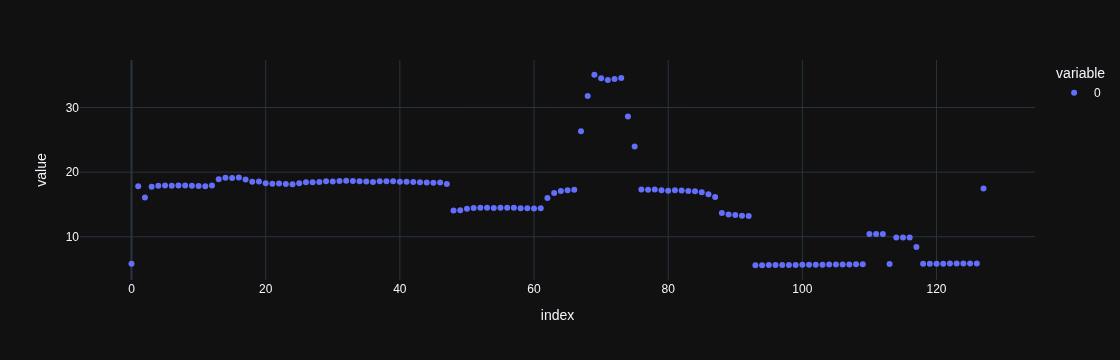

In [11]:
phi = np.arcsin(car_width / r) / constants['angle_increment']
px.scatter(phi)

In [12]:
phi_to_neighbors = np.arange(128)[:, np.newaxis] - np.arange(128)
phi_to_neighbors

array([[   0,   -1,   -2, ..., -125, -126, -127],
       [   1,    0,   -1, ..., -124, -125, -126],
       [   2,    1,    0, ..., -123, -124, -125],
       ...,
       [ 125,  124,  123, ...,    0,   -1,   -2],
       [ 126,  125,  124, ...,    1,    0,   -1],
       [ 127,  126,  125, ...,    2,    1,    0]], shape=(128, 128))

The object at angle $\theta_n$ obstructs neighbor $\theta_{n+k}$ if $\phi_n <= |k|$

In [13]:
obstructed = np.abs(phi_to_neighbors) <= phi

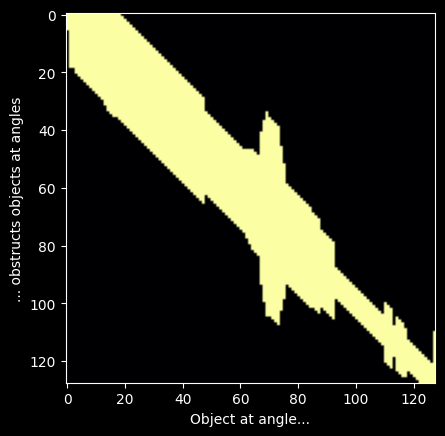

In [14]:
fig, ax = plt.subplots()
ax.set(xlabel='Object at angle...', ylabel='... obstructs objects at angles')
ax.imshow(obstructed, cmap='inferno')

In [26]:
blocking = np.where(obstructed, r, np.nan)

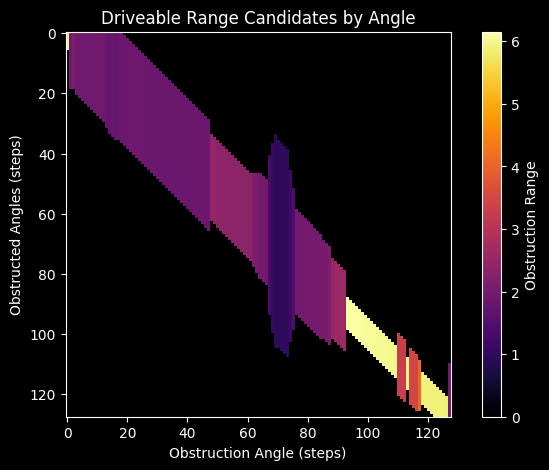

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.set(
    xlabel='Obstruction Angle (steps)',
    ylabel='Obstructed Angles (steps)',
    title='Driveable Range Candidates by Angle',
)
im = ax.imshow(blocking, cmap='inferno', vmin=0)
fig.colorbar(im, label='Obstruction Range')
fig.savefig('./resource/obstruction-map.png')

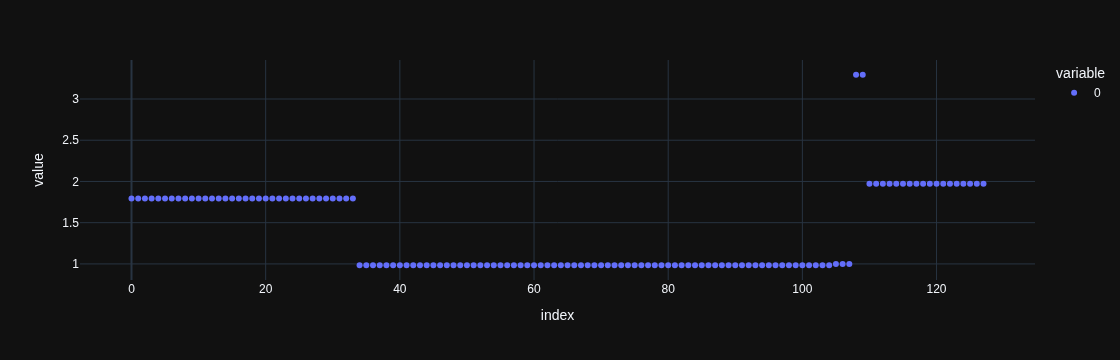

In [29]:
# the effective depth at an angle is the closest distance to any object the car would
# hit at that angle.
effective_depth = np.nanmin(blocking, axis=1)
px.scatter(effective_depth)

In [18]:
direction = effective_depth.argmax()
distance = effective_depth[direction]
print(f'{direction=}, {distance=}')

direction=np.int64(108), distance=np.float64(3.2939999103546143)


In [19]:
is_deepest = np.diff((effective_depth == effective_depth.max()).astype(int))
is_deepest

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0])

In [20]:
(is_deepest.argmin() + is_deepest.argmax() - 1) / 2

np.float64(107.5)

In [21]:
class BestDirectionFinder:

    angle_min = -2.356194496154785
    angle_max = 2.356194496154785
    angle_increment = 0.0043633230961859
    range_min = 0.0199999995529651
    range_max = 30.0

    def __init__(
        self,
        car_size: float = 0.15,  # meters
        nsamples: int = None,
        **kwargs,  # constants about the scan, such as angle_max. etc.
    ):
        self.__dict__.update(kwargs)
        self.car_size = car_size
        self.nsamples = nsamples or abs(int((self.angle_max + self.angle_min) / self.angle_increment))

        # 2x2 matrix where [phi0, phi1] == phi - phi1
        step = np.arange(self.nsamples)
        self.delta_phi = np.abs(step[:, np.newaxis] - step)

        # we can save time mapping elements to angles by doing it once
        self.theta = np.linspace(self.angle_min, self.angle_max, self.nsamples)

    def get_obstruction_matrix(self, r):
        phi = np.arcsin(self.car_size / r) / self.angle_increment  # in steps
        return np.where(self.delta_phi <= phi, r, r[:, np.newaxis])

    def get_obstructed_distance(self, r):
        return self.get_obstruction_matrix(r).min(axis=1)

    def get_drive_angle(self, r):
        d = self.get_obstructed_distance(r)
        bounds = np.diff((d == d.max()).astype(int))  # +1 entering deeoest region, -1 after exiting
        return (bounds.argmin() + bounds.argmax() - 1) / 2

In [22]:
finder = BestDirectionFinder(nsamples=128)

In [23]:
drive_angle = [finder.get_drive_angle(r) for r in tqdm(rs)]

  0%|          | 0/155 [00:00<?, ?it/s]

In [24]:
rs.shape

(155, 128)

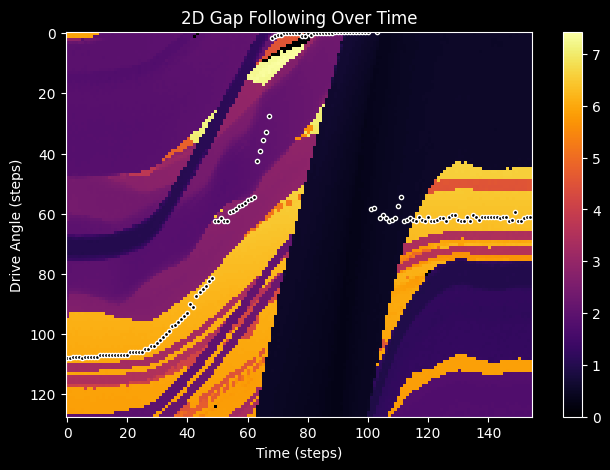

In [25]:
X = rs.T
X[(X < finder.range_min) | (X > finder.range_max)] = np.nan

fig, ax  = plt.subplots(figsize=(8, 5))
ax.set(xlabel='Time (steps)', ylabel='Drive Angle (steps)', title='2D Gap Following Over Time')

im = ax.imshow(X, cmap='inferno', vmin=0)
fig.colorbar(im, ax=ax)

ax.scatter(x=range(len(drive_angle)), y=drive_angle, marker='.', c='black', edgecolors='white')

fig.savefig('./resource/drive-strategy.png')